# Example 1 - a pitch detection network

In this notebook, we wlll train a single-layer network for a super easy task. The goal is to show
how Dense layer is working.

We will use a synthesized data here. It consists of a pure sinusoid on 12 differnt pitches. Then we will compute a CQT and feed one of the CQT frames into the network.

In [95]:
%matplotlib inline
import numpy as np
import librosa
import keras
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Functions to generate data

In [2]:
def sin_wave(secs, freq, sr, gain):
    '''
    Generates a sine wave of frequency given by freq, with duration of secs.
    '''
    t = np.arange(sr * secs)
    return gain * np.sin(2 * np.pi * freq * t / sr)


def whitenoise(gain, shape):
    '''
    Generates white noise of duration given by secs
    '''
    return gain * np.random.uniform(-1., 1., shape)


### A class to generate data batches

In [117]:
class DataGen:
    def __init__(self, sr=16000, batch_size=128):
        np.random.seed(1209)
        self.pitches = [440., 466.2, 493.8, 523.3, 554.4, 587.3,
                        622.3, 659.3, 698.5, 740., 784.0, 830.6]

        self.sr = sr
        self.n_class = len(self.pitches)  # 12 pitches
        self.secs = 1.
        self.batch_size = batch_size
        self.sins = []
        self.labels = np.eye(self.n_class)[range(0, self.n_class)]  # 1-hot-vectors

        for freq in self.pitches:
            cqt = librosa.cqt(sin_wave(self.secs, freq, self.sr, gain=0.5), sr=sr,
                              fmin=220, n_bins=36, filter_scale=2)[:, 1]  # use only one frame!
            cqt = librosa.amplitude_to_db(cqt, ref=np.min)
            cqt = cqt / np.max(cqt)
            self.sins.append(cqt)

        self.cqt_shape = cqt.shape  # (36, )

    def next(self):
        choice = np.random.choice(12, size=self.batch_size, # pick pitches for this batch
                                  replace=True)
        noise_gain = 0.1 * np.random.random_sample(1)  # a random noise gain 
        noise = whitenoise(noise_gain, self.cqt_shape)  # generate white noise
        xs = [noise + self.sins[i] for i in choice]  # compose a batch with additive noise
        ys = [self.labels[i] for i in choice] # corresponding labels

        return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32)


### A quick look on the data we're generating -- and we'll feed as inputs

Input: A frame of CQT in a shape of: (36,)
Number of classes (pitches): 12


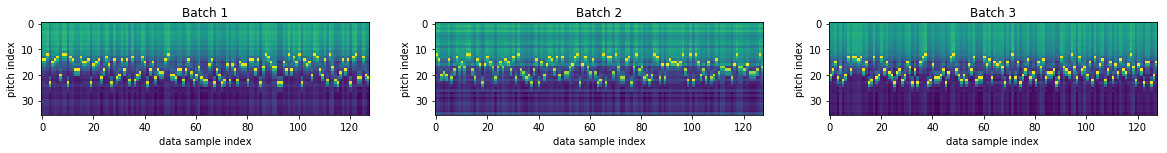

In [118]:
datagen = DataGen()
print("Input: A frame of CQT in a shape of: {}".format(datagen.cqt_shape))
print("Number of classes (pitches): {}".format(datagen.n_class))
x, y = datagen.next()
plt.figure(figsize=(20, 4))
plt.subplot(1, 3, 1)
plt.imshow(x.transpose())
plt.xlabel('data sample index')
plt.ylabel('pitch index')
plt.title('Batch 1')
x, y = datagen.next()
plt.subplot(1, 3, 2)
plt.imshow(x.transpose())
plt.xlabel('data sample index')
plt.ylabel('pitch index')
plt.title('Batch 2')
x, y = datagen.next()
plt.subplot(1, 3, 3)
plt.imshow(x.transpose())
plt.xlabel('data sample index')
plt.ylabel('pitch index')
plt.title('Batch 3')

Each subplot is a visualisation of each batch. The pitch ranges only in [440 Hz, 830 Hz] (A4 - G#5) but the CQT covers wider range of frequencies (3 octaves from 220 Hz to 880 Hz)

### Build a model!

In [119]:
val_datagen = DataGen() # this is a generator for validation set

The model is very simple. No bias, only single dense layer, which will connect a 36-dim input to a 12-dim output.

In [120]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(datagen.n_class, use_bias=False,
                             input_shape=datagen.cqt_shape))
model.add(keras.layers.Activation('softmax'))

model.compile(optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9,
                                             decay=1e-6, nesterov=True),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 12)                432       
_________________________________________________________________
activation_9 (Activation)    (None, 12)                0         
Total params: 432
Trainable params: 432
Non-trainable params: 0
_________________________________________________________________


Number of parameters => $432 = 16 \times 12 $. If there is bias, then it would become $16 \times 12 + 12$.

### Train it!
Alright, let's train it!

In [121]:
history = model.fit_generator(datagen, steps_per_epoch=50, epochs=100, verbose=1,
                             validation_data=val_datagen, validation_steps=4)

Epoch 1/100
50/50 [==============================] - 0s - loss: 2.4519 - acc: 0.1519 - val_loss: 2.3331 - val_acc: 0.2598
Epoch 2/100
50/50 [==============================] - 0s - loss: 2.2479 - acc: 0.4247 - val_loss: 2.1720 - val_acc: 0.5332
Epoch 3/100
50/50 [==============================] - 0s - loss: 2.0864 - acc: 0.7303 - val_loss: 2.0070 - val_acc: 0.8086
Epoch 4/100
50/50 [==============================] - 0s - loss: 1.9386 - acc: 0.8578 - val_loss: 1.8764 - val_acc: 0.7578
Epoch 5/100
50/50 [==============================] - 0s - loss: 1.8009 - acc: 0.9297 - val_loss: 1.7358 - val_acc: 1.0000
Epoch 6/100
50/50 [==============================] - 0s - loss: 1.6754 - acc: 0.9977 - val_loss: 1.6216 - val_acc: 1.0000
Epoch 7/100
50/50 [==============================] - 0s - loss: 1.5570 - acc: 0.9973 - val_loss: 1.4968 - val_acc: 1.0000
Epoch 8/100
50/50 [==============================] - 0s - loss: 1.4579 - acc: 1.0000 - val_loss: 1.3970 - val_acc: 1.0000
Epoch 9/100
50/50 [=====

### What happened?

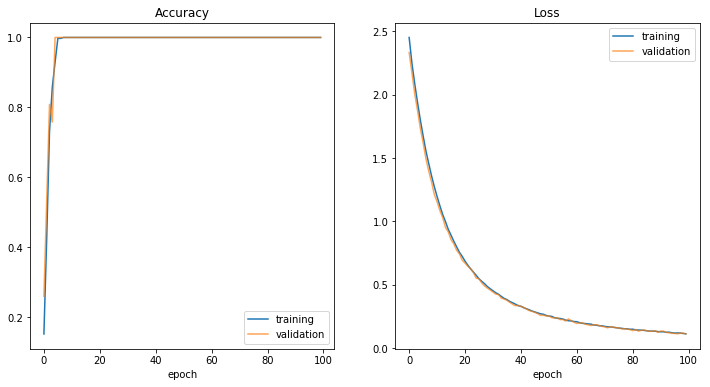

In [157]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='training')
plt.plot(history.history['val_acc'], label='validation', alpha=0.7)
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation', alpha=0.7)
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

Validation set loss is similar to training loss, i.e., no overfitting.

In [123]:
loss = model.evaluate_generator(datagen, steps=10)
print("loss: {}, accuracy: {}".format(loss[0], loss[1]))

loss: 0.111751504242, accuracy: 1.0


### How does the network work after training?

In [124]:
weights = model.get_weights()[0] # (36, 12)
print(weights.shape)
# weights = weights / np.sum(np.abs(weights), axis=1, keepdims=True)

(36, 12)


([], <a list of 0 Text yticklabel objects>)

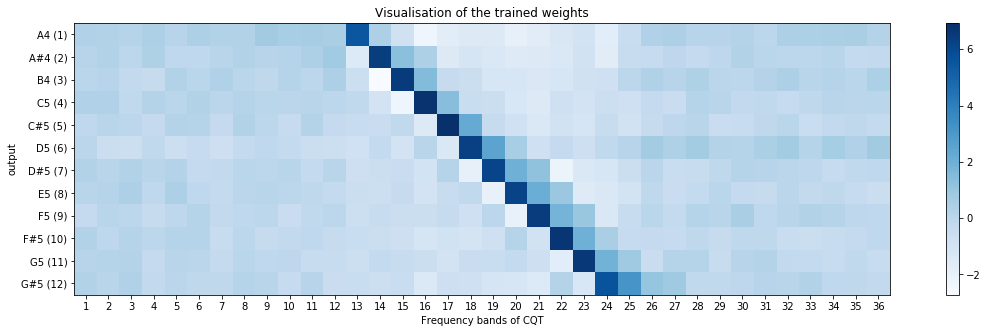

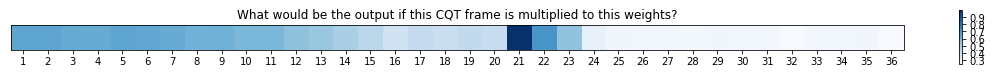

In [149]:
plt.figure(figsize=(20, 5))
plt.imshow(weights.transpose(), cmap=plt.get_cmap('Blues'))
plt.colorbar()
plt.title('Visualisation of the trained weights')
pitch_names = 'A4 A#4 B4 C5 C#5 D5 D#5 E5 F5 F#5 G5 G#5'.split(' ')
plt.yticks(range(0, 12), ['{} ({})'.format(p, str(i)) for p, i in zip(pitch_names, range(1, 13))])
plt.xticks(range(0, 36), [str(i) for i in range(1, 37)])
plt.xlabel('Frequency bands of CQT')
plt.ylabel('output')
plt.figure(figsize=(20, 1))
plt.imshow(x[0:1], cmap=plt.get_cmap('Blues'))
plt.xticks(range(0, 36), [str(i) for i in range(1, 37)])
plt.colorbar()
plt.title('What would be the output if this CQT frame is multiplied to this weights?')
plt.yticks([])

This is visualisation of weights $\textbf{W}$.

Each row corresponeds to each output node. For example, the 1st row (A4) is connected to the 1st output node, which will be activated (has a large value) if the network thinks it is A4.


In [155]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=0)

output_for_x = softmax(np.dot(weights.transpose(), x[0]))
print('Output node values for x[0]: ')
print(output_for_x)
print('Estimated pitch: {}'.format(pitch_names[np.argmax(output_for_x)]))
print('Groundtruth: {}'.format(pitch_names[np.argmax(y[0])]))

Output node values for x[0]: 
[ 0.00398768  0.00208454  0.00237309  0.00158034  0.00181304  0.00518177
  0.0081431   0.02542128  0.90895289  0.03282993  0.00641673  0.00121559]
Estimated pitch: F5
Groundtruth: F5
